In [5]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, assemble, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.algorithms import AmplificationProblem, Grover

## QROM

In [6]:
def qrom(database, name="db"):
    # Check if database is binary
    assert ((database == 0) | (database == 1)).all()
    
    def encode_row(i):
        row = database[i]
        for j in range(len(row)):
            if row[j] == 1:
                qc.mct(addr_qreg, data_qreg[j])

    def bit_diff_pos(a, b):
        return (addrs[i] ^ addrs[i-1]).bit_length() - 1

    def grey_code(n):
        return n ^ (n >> 1)
    
    nrows, ncols = database.shape
    addr_size = math.ceil(math.log2(nrows))
    addrs = [grey_code(n) for n in range(nrows)]
    
    addr_qreg = QuantumRegister(addr_size, name=f"{name}-address")
    data_qreg = QuantumRegister(ncols, name=f"{name}-data")
    
    qc = QuantumCircuit(addr_qreg, data_qreg)
    
    qc.x(addr_qreg)
    encode_row(0)
    
    qc.barrier()
    
    for i in range(1, len(addrs)):
        qc.x(addr_qreg[bit_diff_pos(addrs[i], addrs[i-1])])
        encode_row(addrs[i])
        qc.barrier()
    
    qc.name = name
    
    return qc

## Inner Product (out of place)

In [7]:
def inner_product(reg_sz, name="dot"):
    a = QuantumRegister(reg_sz, name=f"{name}_a")
    b = QuantumRegister(reg_sz, name=f"{name}_b")
    out = QuantumRegister(1, name=f"{name}_out")

    qc = QuantumCircuit(a, b, out)
    
    for i in range(reg_sz):
        qc.mct([a[i], b[i]], out)
        
    qc.name = name
    
    return qc

## Grover circuit

In [8]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)

    for qubit in range(nqubits):
        qc.h(qubit)

    for qubit in range(nqubits):
        qc.x(qubit)

    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)

    for qubit in range(nqubits):
        qc.x(qubit)

    for qubit in range(nqubits):
        qc.h(qubit)

    U_s = qc.to_gate()
    U_s.name = "diffuser"
    return U_s

In [9]:
def encode_vector(qc, qreg, vec):
    a = vec.reshape(-1)
    
    for i in range(len(a)):
        if a[i] == 1:
            qc.x(qreg[i])

In [10]:
def gen_input(dim, num_incorrect, seed=None):
    if seed is not None:
        np.random.seed(seed)
    nrows, ncols = dim
    A = np.random.randint(0, 2, dim)
    y = np.random.randint(0, 2, (ncols,))
    z = A@y % 2

    idx = np.random.choice(range(0, nrows), num_incorrect, replace=False)
    for i in idx:
        z[i] = not z[i]

    return A, y, z, idx

In [11]:
def qvmp_grover_submatrix(A, y, z, num_solutions, num_iterations=None, with_amplitude_amplification=False):
    db = np.concatenate((A, z.reshape((1, -1)).T), axis=1)
    nrows, ncols = A.shape
    addr_size = math.ceil(math.log2(nrows))

    addr_qreg = QuantumRegister(addr_size, name="address")
    A_qreg = QuantumRegister(ncols, name="a")
    y_qreg = QuantumRegister(ncols, name="y")
    z_qreg = QuantumRegister(1, name="z")

    data_out = ClassicalRegister(addr_size, name="data")

    qc = QuantumCircuit(addr_qreg, A_qreg, y_qreg, z_qreg, data_out)
    
    qc.h(addr_qreg)
    encode_vector(qc, y_qreg, y)
    qc.barrier()

    qdb = qrom(db)
    dot = inner_product(ncols)

    if num_iterations is None:
        if num_solutions == 0:
            num_iterations = 1
        else:
            num_iterations = Grover.optimal_num_iterations(num_solutions, addr_size)
        
    num_aa_iterations = math.sqrt(num_iterations)
    if num_aa_iterations.is_integer():
        num_aa_iterations = math.floor(num_aa_iterations) + 1
    else:
        num_aa_iterations = math.floor(num_aa_iterations)
    
    def do_grover_iterations():
        for i in range(num_iterations):
            qc.append(qdb, [*addr_qreg, *A_qreg, *z_qreg])
            qc.append(dot, [*A_qreg, *y_qreg, *z_qreg])

            qc.z(z_qreg)

            qc.append(dot.inverse(), [*A_qreg, *y_qreg, *z_qreg])
            qc.append(qdb.inverse(), [*addr_qreg, *A_qreg, *z_qreg])

            qc.barrier()

            qc.append(diffuser(addr_size), [*addr_qreg])
    
    if with_amplitude_amplification:
        for j in range(num_aa_iterations):
            do_grover_iterations()
            qc.barrier()
            qc.append(diffuser(addr_size), [*addr_qreg])
    else:
        do_grover_iterations()
        
    qc.barrier()

    qc.measure([*addr_qreg], data_out)
    
    return qc, num_iterations

In [12]:
def run_experiment(dims, num_incorrect, seed, is_known):
    nrows, ncols = dims
    A, y, z, idx = gen_input(dims, num_incorrect, seed=seed)

    if is_known:
        qc, num_iterations = qvmp_grover_submatrix(A, y, z, num_incorrect)
    else:
        qc, num_iterations = qvmp_grover_submatrix(
            A, y, z,
            num_incorrect,
            num_iterations=math.floor(nrows ** 0.5),
            with_amplitude_amplification=True
        )
      
    backend = AerSimulator(method="statevector")
    qobj = assemble(transpile(qc, backend))
    result = backend.run(qobj).result()

    return result, idx, num_iterations

## Figures

In [13]:
seed = 42

In [30]:
# fig:qvmp_functionality_found_known
result, idx, num_iterations = run_experiment((8,8), 3, seed, is_known=True)
plot_histogram(result.get_counts()).savefig("../results/figures/qvmp_functionality_found_known.pdf")

In [31]:
# fig:qvmp_functionality_found_unknown
result, idx, num_iterations = run_experiment((8,8), 3, seed, is_known=False)
plot_histogram(result.get_counts()).savefig("../results/figures/qvmp_functionality_found_unknown.pdf")

In [32]:
# fig:qvmp_functionality_none_known
result, idx, num_iterations = run_experiment((8,8), 0, seed, is_known=True)
plot_histogram(result.get_counts()).savefig("../results/figures/qvmp_functionality_none_known.pdf")

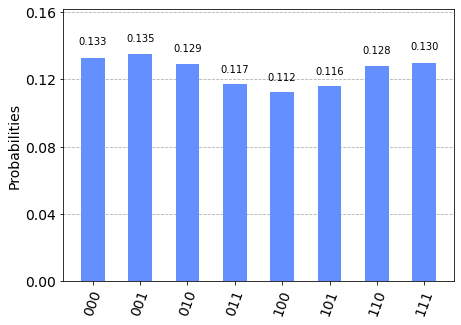

In [18]:
# fig:qvmp_functionality_none_unknown
result, idx, num_iterations = run_experiment((8,8), 0, seed, is_known=False)
plot_histogram(result.get_counts()).savefig("../results/figures/qvmp_fu")

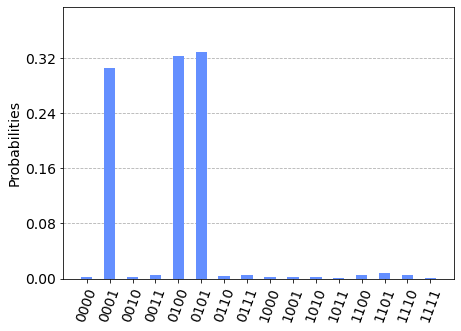

In [29]:
# fig:qvmp_functionality_pfound_known__1
result, idx, num_iterations = run_experiment((16,8), 3, seed, is_known=True)
plot_histogram(result.get_counts(), bar_labels=False)

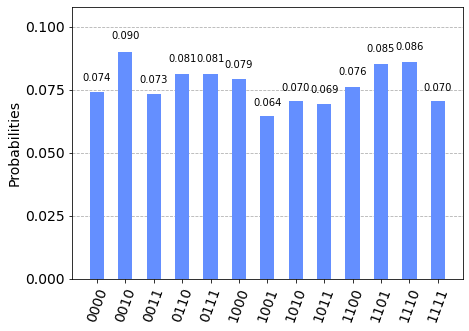

In [27]:
# fig:qvmp_functionality_pfound_unknown__1
result, idx, num_iterations = run_experiment((16,8), 3, seed, is_known=False)
plot_histogram(result.get_counts())

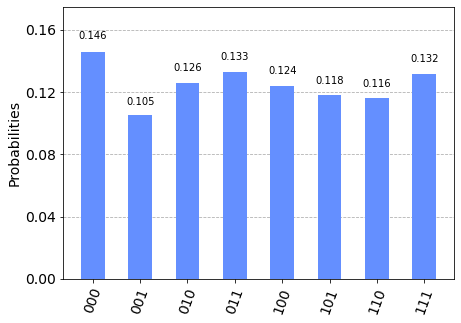

In [28]:
# fig:qvmp_functionality_pfound_known__2
result, idx, num_iterations = run_experiment((8,8), 5, seed, is_known=True)
plot_histogram(result.get_counts())